In [1]:
import torch
import time
import dlc_practical_prologue as prologue
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
 

In [2]:
def sigma(x):
    return torch.tanh(x)
def dsigma(x):
    # return torch.pow(torch.cosh(x), -2)
    return 1 - torch.pow(torch.tanh(x), 2)

In [3]:
def loss(v, t):
    error = t - v
    return torch.sum(torch.pow(error.mul(error), 2))
def dloss(v, t):
    error = t - v
    return -2 * error

In [4]:
def forward_pass(w1, b1, w2, b2, x):

    s1 = x.mm(w1) + b1
    x1 = sigma(s1)
    s2 = x1.mm(w2) + b2
    x2 = sigma(s2)

    return x, s1, x1, s2, x2

def backward_pass(w1, b1, w2, b2,
                t, 
                x, s1, x1, s2, x2,
                dl_dw1, dl_db1, dl_dw2, dl_db2):
    # Initialize backward pass
    # since we are using MSE loss:
    delta2 = dloss(x2, t) * dsigma(s2)
    
    delta1 = delta2.mm(w2.t()) * dsigma(s1)
    
    dl_dw2 += delta2[:,None,:] * x1[:,:,None]
    dl_db2 += delta2
    dl_dw1 += delta1[:,None,:] * x0[:,:,None]
    dl_db1 += delta1
    

    







In [5]:
train_input, train_target, test_input, test_target = prologue.load_data(cifar = None, one_hot_labels = True, normalize = True, flatten = True)
print(train_input.shape, train_target.shape)
train_target*=0.9
test_target*=0.9
train_input = train_input.to(device)
train_target = train_target.to(device)
test_input = test_input.to(device)
test_target = test_target.to(device)


* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples
torch.Size([1000, 784]) torch.Size([1000, 10])


In [6]:
in_dim = 784
h_dim = 50
out_dim=10
epsilon=1e-6
eta0 = 0.1
n_samples = train_input.shape[0]

w1 = torch.empty((in_dim, h_dim)).normal_(mean=0, std=epsilon).to(device)
b1 = torch.empty((h_dim)).normal_(mean=0, std=epsilon).to(device)
w2 = torch.empty((h_dim, out_dim)).normal_(mean=0, std=epsilon).to(device)
b2 = torch.empty((out_dim)).normal_(mean=0, std=epsilon).to(device)

dl_dw2 = torch.empty((n_samples, h_dim, out_dim)).fill_(0).to(device)
dl_db2 = torch.empty((n_samples, out_dim)).fill_(0).to(device)
dl_dw1 = torch.empty((n_samples, in_dim, h_dim)).fill_(0).to(device)
dl_db1 = torch.empty((n_samples, h_dim)).fill_(0).to(device)
n_updates=1000
train_loss=[]
test_loss=[]
start_time=time.time()
for niter in range(n_updates):
    
    x0, s1, x1, s2, x2 = forward_pass(w1, b1, w2, b2, train_input)
    train_loss.append(loss(x2, train_target)/train_input.shape[0])
    train_predicted = torch.argmax(x2, axis=1)
    train_target_class = torch.argmax(train_target, axis=1)
    

    _, _, _, _, x2_test = forward_pass(w1, b1, w2, b2, test_input)
    test_loss.append(loss(x2_test, test_target)/test_input.shape[0])
    test_predicted = torch.argmax(x2_test, axis=1)
    test_target_class = torch.argmax(test_target, axis=1)

    

    backward_pass(w1, b1, w2, b2, train_target, x0, s1, x1, s2, x2, dl_dw1, dl_db1, dl_dw2, dl_db2)
    w1 = w1 - eta0 * dl_dw1.mean(axis=0)
    b1 = b1 - eta0 * dl_db1.mean(axis=0)
    w2 = w2 - eta0 * dl_dw2.mean(axis=0)
    b2 = b2 - eta0 * dl_db2.mean(axis=0)

    # This is probably not necessary since I am working on batches:
    dl_dw1.fill_(0)
    dl_db1.fill_(0)
    dl_dw2.fill_(0)
    dl_db2.fill_(0)
    if niter%100==0:
        #print(test_predicted, test_target_class)
        print(f"Train error = {(~(train_predicted==train_target_class)).float().mean()}, Test error = {(~(test_predicted==test_target_class)).float().mean()}")
    
print(f"Training took {time.time() - start_time} s")

Train error = 0.9030000567436218, Test error = 0.9150000214576721
Train error = 0.1940000057220459, Test error = 0.29200002551078796
Train error = 0.055000003427267075, Test error = 0.164000004529953
Train error = 0.05700000375509262, Test error = 0.2240000069141388
Train error = 0.024000000208616257, Test error = 0.14800000190734863
Train error = 0.01900000125169754, Test error = 0.15600000321865082
Train error = 0.009000000543892384, Test error = 0.1510000079870224
Train error = 0.01100000087171793, Test error = 0.1510000079870224
Train error = 0.003000000026077032, Test error = 0.14800000190734863
Train error = 0.0010000000474974513, Test error = 0.13900001347064972
Training took 27.104968309402466 s


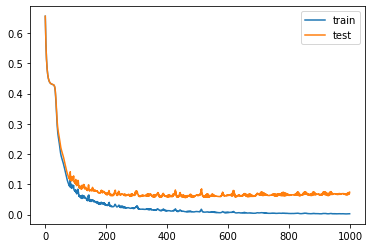

In [7]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()